# Example of using _mlreflect_ for training

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from mlreflect.models import DefaultTrainedModel, TrainedModel
from mlreflect.data_generation import ReflectivityGenerator, noise
from mlreflect.training import InputPreprocessor, OutputPreprocessor, NoiseGenerator
from mlreflect.curve_fitter import CurveFitter
from mlreflect.utils.naming import make_timestamp
from tensorflow import keras

## Load values from the default model (as published in Greco _et al._ 2022)

In [3]:
q_values = DefaultTrainedModel().q_values
sample = DefaultTrainedModel().sample

In [4]:
print(sample)

Air (ambient):
	sld: 0 [1e-6 1/Å^2]
[1] Film:
	thickness: (20, 1000) [Å]
	roughness: (0, 100) [Å]
	sld: (1, 14) [1e-6 1/Å^2]
[0] SiOx:
	thickness: 10.0 [Å]
	roughness: 2.5 [Å]
	sld: (17.7735+0.4048j) [1e-6 1/Å^2]
Si (substrate):
	roughness: 1 [Å]
	sld: (20.0701+0.4571j) [1e-6 1/Å^2]


## Generate input and output

In [5]:
generator = ReflectivityGenerator(q_values, sample)

In [6]:
n_total = 1024
labels = generator.generate_random_labels(n_total)
reflectivity = generator.simulate_reflectivity(labels)

100%|██████████| 1024/1024 [00:00<00:00, 2429.66it/s]


In [7]:
labels

,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,Air_sld
0,10.0,845.343153,1,2.5,82.149175,20.070100+0.457100j,17.773500+0.404800j,4.892686,0
1,10.0,644.344941,1,2.5,46.794991,20.070100+0.457100j,17.773500+0.404800j,11.573219,0
2,10.0,257.776751,1,2.5,86.304737,20.070100+0.457100j,17.773500+0.404800j,7.258925,0
3,10.0,84.807697,1,2.5,0.823161,20.070100+0.457100j,17.773500+0.404800j,13.450039,0
4,10.0,930.585510,1,2.5,7.562076,20.070100+0.457100j,17.773500+0.404800j,4.004579,0
...,...,...,...,...,...,...,...,...,...
1019,10.0,812.626239,1,2.5,40.447089,20.070100+0.457100j,17.773500+0.404800j,9.977775,0
1020,10.0,314.234065,1,2.5,55.426937,20.070100+0.457100j,17.773500+0.404800j,4.303279,0
1021,10.0,277.641660,1,2.5,11.715982,20.070100+0.457100j,17.773500+0.404800j,13.396382,0
1022,10.0,888.079671,1,2.5,40.142580,20.070100+0.457100j,17.773500+0.404800j,4.964635,0


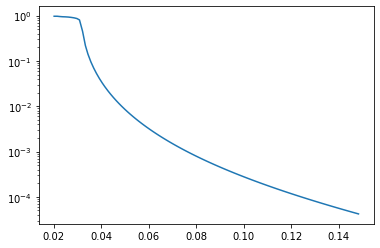

In [8]:
plt.semilogy(q_values, reflectivity[31])

While looking into this, I saw that most of the curves are actually flat due to the very high range of roughness. This might affect training and it might be useful to filter those out in the future.

## Setup preprocessors

### Output preprocessing

In [9]:
op = OutputPreprocessor(sample, normalization='min_to_zero')

In [10]:
preprocessed_labels, removed_labels = op.apply_preprocessing(labels)

In [11]:
preprocessed_labels

,Film_thickness,Film_roughness,Film_sld
0,0.842187,0.821492,0.299437
1,0.637087,0.467950,0.813325
2,0.242629,0.863047,0.481456
3,0.066130,0.008232,0.957695
4,0.929169,0.075621,0.231121
...,...,...,...
1019,0.808802,0.404471,0.690598
1020,0.300239,0.554269,0.254098
1021,0.262900,0.117160,0.953568
1022,0.885796,0.401426,0.304972


In [12]:
removed_labels

,SiOx_thickness,Si_roughness,SiOx_roughness,Si_sld,SiOx_sld,Air_sld
0,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0
1,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0
2,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0
3,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0
4,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0
...,...,...,...,...,...,...
1019,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0
1020,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0
1021,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0
1022,10.0,1,2.5,20.070100+0.457100j,17.773500+0.404800j,0


### Input preprocessing

#### Define noise levels

These are the noise levels I used in Greco _et al._ 2022.

In [13]:
uniform_noise_range = (0.7, 1.3)
scaling_noise_range = (0.8, 1.2)

#### Determine standardization parameters of the noisy input

In [14]:
ip = InputPreprocessor()
ip.standardize(
    noise.apply_scaling_factor(
        noise.apply_uniform_noise(reflectivity, uniform_noise_range),
        scaling_noise_range)
);

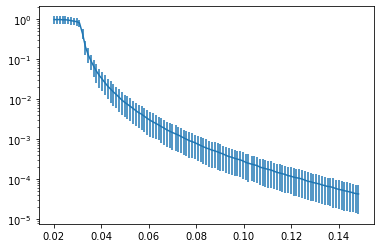

In [15]:
plt.errorbar(q_values, ip.standard_mean, yerr=ip.standard_std)
plt.yscale('log')
plt.show()

## Make Keras model

This is the main part that we want to change (by using a CNN model instead).

In [16]:
def make_fully_connected_model(n_input: int, n_output: int):
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(512, input_dim=n_input))
    
    model.add(keras.layers.Activation('relu'))

    for i in range(2):
        model.add(keras.layers.Dense(512))
        model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Dense(n_output))

    adam_optimizer = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0, amsgrad=False)

    model.compile(loss='mean_squared_error', optimizer=adam_optimizer)

    return model

In [18]:
n_input = reflectivity.shape[1]
n_output = preprocessed_labels.shape[1]
keras_model = make_fully_connected_model(n_input, n_output)
print(n_output)

3


## Define Dataloader for Keras

### Define a subclass of NoiseGenerator from the _mlreflect_ package that implements uniform noise and curve scaling

In [19]:
class UniformNoiseGenerator(NoiseGenerator):
    def __init__(self, reflectivity, labels, ip, batch_size=32, mode='single', shuffle=True, uniform_noise_range=(1, 1),
                 scaling_range=(1, 1)):
        super().__init__(reflectivity, labels, ip, batch_size=batch_size, mode=mode, shuffle=shuffle,
                         noise_range=None, background_range=None,
                         relative_background_spread=0)
        self.uniform_noise_range = uniform_noise_range
        self.scaling_range = scaling_range
        self.ip = ip

    def __data_generation(self, indexes):
        refl = self.reflectivity[indexes]
        refl = noise.apply_scaling_factor(noise.apply_uniform_noise(refl, self.uniform_noise_range),
                                          self.scaling_range)

        return self.ip.standardize(refl), np.array(self.labels)[indexes]
        
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        x, y = self.__data_generation(indexes)

        return x, y, [None]

### Create a dataloader for both the training and validation data

In [20]:
n_train = int(25/30 * len(reflectivity))
print(n_train)

853


In [21]:
batch_size = 64

Actually, the I chose a batch size of 512, but for this demonstration I reduced it, because the batch size cannot be larger than the training or validation set size.
Also, ideally both the training and validation set size should be a power of 2 (I know it isn't in my case either).

In [22]:
datagen_train = UniformNoiseGenerator(reflectivity=reflectivity[:n_train],
                                      labels=preprocessed_labels[:n_train],
                                      ip=ip,
                                      batch_size=batch_size,
                                      uniform_noise_range=uniform_noise_range,
                                      scaling_range=scaling_noise_range)

datagen_val = UniformNoiseGenerator(reflectivity=reflectivity[n_train:],
                                    labels=preprocessed_labels[n_train:],
                                    ip=ip,
                                    batch_size=batch_size,
                                    uniform_noise_range=uniform_noise_range,
                                    scaling_range=scaling_noise_range)

## Train the model

### Generate training ID for later identifcation

In [23]:
time_stamp = make_timestamp()
experiment_id = 'example_model_' + time_stamp
print(experiment_id)

example_model_2022-06-10-160714


### Create callbacks

In [24]:
# This callback halves the learning rate whenever the loss stagnates for 10 epochs in a row
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, verbose=1)

# This callback always saves model with the best val_loss across the entire training to a file
checkpoint = keras.callbacks.ModelCheckpoint(filepath='models/' + experiment_id + '_model.h5', monitor='val_loss',
                                             verbose=1, save_best_only=True)

# This callback allows monitoring of the training via tensorboard
tb_callback = keras.callbacks.TensorBoard(log_dir='tensorboard/' + experiment_id, histogram_freq=0,
                                          write_graph=True, write_images=False)

### Run training

In [25]:
epochs = 10
output = keras_model.fit(datagen_train, validation_data=datagen_val,
                   epochs=epochs, verbose=1, callbacks=[lr_reduction,
                                                        tb_callback,
#                                                         checkpoint
                                                       ])

Train for 13 steps, validate for 2 steps
Epoch 1/10
13/13 [==============================] - 1s 108ms/step - loss: 0.2056 - val_loss: 0.0915
Epoch 2/10
13/13 [==============================] - 0s 34ms/step - loss: 0.0815 - val_loss: 0.0855
Epoch 3/10
13/13 [==============================] - 0s 37ms/step - loss: 0.0694 - val_loss: 0.0665
Epoch 4/10
13/13 [==============================] - 0s 30ms/step - loss: 0.0621 - val_loss: 0.0617
Epoch 5/10
13/13 [==============================] - 0s 27ms/step - loss: 0.0569 - val_loss: 0.0632
Epoch 6/10
13/13 [==============================] - 0s 26ms/step - loss: 0.0529 - val_loss: 0.0650
Epoch 7/10
13/13 [==============================] - 0s 36ms/step - loss: 0.0495 - val_loss: 0.0611
Epoch 8/10
13/13 [==============================] - 0s 32ms/step - loss: 0.0497 - val_loss: 0.0515
Epoch 9/10
13/13 [==============================] - 0s 34ms/step - loss: 0.0465 - val_loss: 0.0462
Epoch 10/10
13/13 [==============================] - 1s 42ms/step -

## Prediction on test data

### Generate test set

In [19]:
test_labels = generator.generate_random_labels(100)
test_refl = generator.simulate_reflectivity(test_labels)
print(test_refl.shape)

100%|██████████| 100/100 [00:00<00:00, 7903.79it/s]

(100, 109)


### Generate predictions

In [38]:
raw_predictions = keras_model.predict(ip.standardize(test_refl)) # this is just an ndarray

In [39]:
raw_predictions

array([[ 8.53584588e-01,  1.23834103e-01,  5.35818517e-01],
       [ 2.83375353e-01,  4.44038481e-01,  2.01495007e-01],
       [ 6.76008523e-01,  6.05242372e-01,  8.07248473e-01],
       [ 3.94462705e-01,  3.61842573e-01,  3.92419219e-01],
       [ 3.82615745e-01,  4.72637892e-01,  4.44122821e-01],
       [ 6.75920188e-01,  5.29231906e-01,  8.97382617e-01],
       [ 2.41056234e-02, -6.67510182e-03,  2.26330549e-01],
       [ 3.48755509e-01,  3.52264762e-01, -6.26814086e-03],
       [ 2.88708061e-01,  4.41959053e-01,  2.30070472e-01],
       [ 6.38695121e-01,  7.02968955e-01,  9.06913877e-01],
       [ 1.02753615e+00,  2.10766837e-01,  7.26663172e-01],
       [ 5.34727991e-01,  4.78139877e-01,  6.92767501e-01],
       [ 2.66684264e-01,  3.48953843e-01,  4.17735100e-01],
       [ 6.90122068e-01, -1.49602696e-01,  7.99934983e-01],
       [-1.21825658e-01,  3.52132656e-02,  2.12087855e-01],
       [ 2.75579691e-01,  3.64155650e-01,  6.83619007e-02],
       [ 3.92209321e-01,  3.43221366e-01

In [ ]:
predictions = op.restore_labels(raw_predictions)

In [ ]:
predictions

,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,Air_sld
0,10.0,670.117493,1,2.5,0.108434,20.0701+0.4571j,17.7735+0.4048j,9.837955,0
1,10.0,250.513947,1,2.5,42.353867,20.0701+0.4571j,17.7735+0.4048j,2.381674,0
2,10.0,310.760956,1,2.5,51.648800,20.0701+0.4571j,17.7735+0.4048j,7.735473,0
3,10.0,309.077087,1,2.5,54.891361,20.0701+0.4571j,17.7735+0.4048j,10.454546,0
4,10.0,340.562653,1,2.5,42.477261,20.0701+0.4571j,17.7735+0.4048j,7.282632,0
...,...,...,...,...,...,...,...,...,...
95,10.0,749.328186,1,2.5,0.065444,20.0701+0.4571j,17.7735+0.4048j,11.421221,0
96,10.0,-51.903999,1,2.5,-2.742435,20.0701+0.4571j,17.7735+0.4048j,12.897709,0
97,10.0,603.963623,1,2.5,44.955704,20.0701+0.4571j,17.7735+0.4048j,2.932298,0
98,10.0,341.091797,1,2.5,35.542915,20.0701+0.4571j,17.7735+0.4048j,4.234014,0


In [ ]:
predicted_refl = generator.simulate_reflectivity(predictions)

100%|██████████| 100/100 [00:00<00:00, 7228.44it/s]


Of course this model isn't trained properly and the predictions are bad, but just for demonstration, we can plot it.

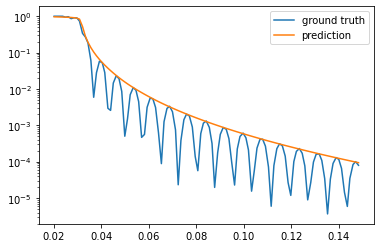

In [ ]:
plt.semilogy(q_values, reflectivity[30], label='ground truth')
plt.semilogy(q_values, predicted_refl[30], label='prediction')
plt.legend()
plt.show()

At this point you can calculate various metrics between the predictions and the ground truth (with labels and the curves) to judge the performance.
At this point you can also use an experimental test set to see if the model works correctly.

## Wrap keras model in a `TrainedModel` class

In [ ]:
trained_model = TrainedModel()
trained_model.from_variable(model=keras_model,
                            sample=sample,
                            q_values=q_values,
                            ip_mean=ip.standard_mean,
                            ip_std=ip.standard_std)

The `TrainedModel` can be saved and loaded to/from h5.

In [ ]:
# trained_model.save_model(experiment_id + '_trained_model.h5')
# trained_model.from_file(experiment_id + '_trained_model.h5')

## Use the trained model in the `CurveFitter` class

In [ ]:
curve_fitter = CurveFitter(trained_model)

In [ ]:
fit_results = curve_fitter.fit_curve(test_refl, q_values, polish=False, optimize_q=False)

If `polish` (LMS fit) and `optimize_q` (_q_ shifting) are turned off, the result should be the same as above. `polish=True` is usually recommended, but takes longer. `optimize_q` also takes much longer and might not be necessary for a CNN. The differences are discussed in the paper Greco _et al._ 2022. The additional time is not so noticeable for a few experimental curves, but for 10k simulated test curves it can increase the time from milliseconds to half an hour. To optimize this, it could probably also be implemented to run on a GPU.

In [ ]:
fit_results['predicted_reflectivity']

array([[9.99957069e-01, 9.99733794e-01, 9.96758501e-01, ...,
        7.09174492e-06, 3.14600527e-06, 3.03941706e-05],
       [9.61826327e-01, 9.55846915e-01, 9.50773757e-01, ...,
        8.13078585e-05, 7.84182303e-05, 7.53850429e-05],
       [9.94162211e-01, 9.86875932e-01, 9.71219079e-01, ...,
        3.67495593e-05, 3.53839053e-05, 3.39521315e-05],
       ...,
       [9.66463603e-01, 9.56009091e-01, 9.50417166e-01, ...,
        7.59319767e-05, 7.32239336e-05, 7.03816341e-05],
       [9.58169243e-01, 9.51659109e-01, 9.51057586e-01, ...,
        6.39396382e-05, 6.16385143e-05, 5.92239102e-05],
       [9.82996779e-01, 9.68218616e-01, 9.50481578e-01, ...,
        4.90060152e-05, 4.72159852e-05, 4.53384392e-05]])

In [ ]:
fit_results['predicted_parameters']

,SiOx_thickness,Film_thickness,Si_roughness,SiOx_roughness,Film_roughness,Si_sld,SiOx_sld,Film_sld,Air_sld
0,10.0,670.117493,1,2.5,0.108434,20.0701+0.4571j,17.7735+0.4048j,9.837955,0
1,10.0,250.513947,1,2.5,42.353867,20.0701+0.4571j,17.7735+0.4048j,2.381674,0
2,10.0,310.760956,1,2.5,51.648800,20.0701+0.4571j,17.7735+0.4048j,7.735473,0
3,10.0,309.077087,1,2.5,54.891361,20.0701+0.4571j,17.7735+0.4048j,10.454546,0
4,10.0,340.562653,1,2.5,42.477261,20.0701+0.4571j,17.7735+0.4048j,7.282632,0
...,...,...,...,...,...,...,...,...,...
95,10.0,749.328186,1,2.5,0.065444,20.0701+0.4571j,17.7735+0.4048j,11.421221,0
96,10.0,51.903999,1,2.5,2.742435,20.0701+0.4571j,17.7735+0.4048j,12.897709,0
97,10.0,603.963623,1,2.5,44.955704,20.0701+0.4571j,17.7735+0.4048j,2.932298,0
98,10.0,341.091797,1,2.5,35.542915,20.0701+0.4571j,17.7735+0.4048j,4.234014,0


## Extra part for _mlreflect_ in field use

This part is probably not necessary for a bachelor project, but is relevant to the implementation at P08/DESY and at our home XRR machine.

### Import SpecFitter class

In [ ]:
from mlreflect.curve_fitter import SpecFitter

In [ ]:
spec_fitter = SpecFitter()
spec_fitter.set_trained_model(trained_model)

In [ ]:
spec_params = {
    'angle_columns': ['tt'],
    'intensity_column': "p100k_roi2",
    'attenuator_column': 'atten_position'
}

spec_fitter.set_import_params(**spec_params)

In [ ]:
footprint_params = {
    'wavelength': 0.6889,
    'beam_width': 0.072,
    'sample_length': 10
}

spec_fitter.set_footprint_params(**footprint_params)

In [ ]:
# The path to the SPEC file (it has to exist)
# spec_fitter.set_file('path/to/file')

The rest is explained in in the documentation under "SpecFitter example".